# CICD Pipelines
This has largely been taken from [how to build a modern cicd pipeline](https://medium.com/bettercode/how-to-build-a-modern-ci-cd-pipeline-5faa01891a5b). 

## Add a .gitignore
We do not want to load our 'env' folder and all of the contents to github.

In [1]:
import os

file_name = ".gitignore"

content = '''
env/
.ipynb_checkpoints/
.pytest_cache/
__pycache__/
'''

with open(file_name, "w") as target_file:
    target_file.write(content)


## Commit this to github
We have the repo [here](https://github.com/simongarisch/cicd_setup).

## Our environment
We are going to manage the environment with virtualenv

In [2]:
%%bash
source activate py36
virtualenv env

Using base prefix 'c:\\anaconda2\\envs\\py36'
  No LICENSE.txt / LICENSE found in source
New python executable in U:\git\cicd_setup\env\Scripts\python.exe
Installing setuptools, pip, wheel...
done.


In [ ]:
%%bash
source env/scripts/activate
pip install pytest
pip install flask
pip install black

Use this environment to create a requirements.txt file.

In [5]:
%%bash
source env/scripts/activate
pip freeze > requirements.txt

## The script
First we start with a very basic python script...

In [6]:
pycode = '''

def meaning_of_life():
    return 42


def main():
    print(meaning_of_life())


if __name__ == "__main__":
    main()
'''

In [7]:
exec(pycode)

42


In [8]:
import os

file_name = "meaning.py"
with open(file_name, "w") as target_file:
    target_file.write(pycode)


In [9]:
%%bash
cat meaning.py



def meaning_of_life():
    return 42


def main():
    print(meaning_of_life())


if __name__ == "__main__":
    main()


## Testing the script

In [10]:
test_code = """
import pytest
import meaning

def test_meaning():
    assert meaning.meaning_of_life() == 42
"""

In [11]:
file_name = "test_meaning.py"
with open(file_name, "w") as target_file:
    target_file.write(test_code)


In [12]:
%%bash
cat test_meaning.py


import pytest
import meaning

def test_meaning():
    assert meaning.meaning_of_life() == 42


In [13]:
%%bash
source env/scripts/activate
pytest

============================= test session starts =============================
platform win32 -- Python 3.6.6, pytest-4.6.3, py-1.8.0, pluggy-0.12.0
rootdir: U:\git\cicd_setup
collected 1 item

test_meaning.py .                                                        [100%]

========================== 1 passed in 0.39 seconds ===========================


Tests are passing!

## Use Travis CI for Continuous Integration
* Login via https://travis-ci.org/
* Enable your repo in the section https://travis-ci.org/account/repositories
* Commit your changes to github

In [15]:
import os

file_name = ".travis.yml"

content = '''
language: python
script:
  - python -m pytest
'''

with open(file_name, "w") as target_file:
    target_file.write(content)


Travis will then run tests on this repo...

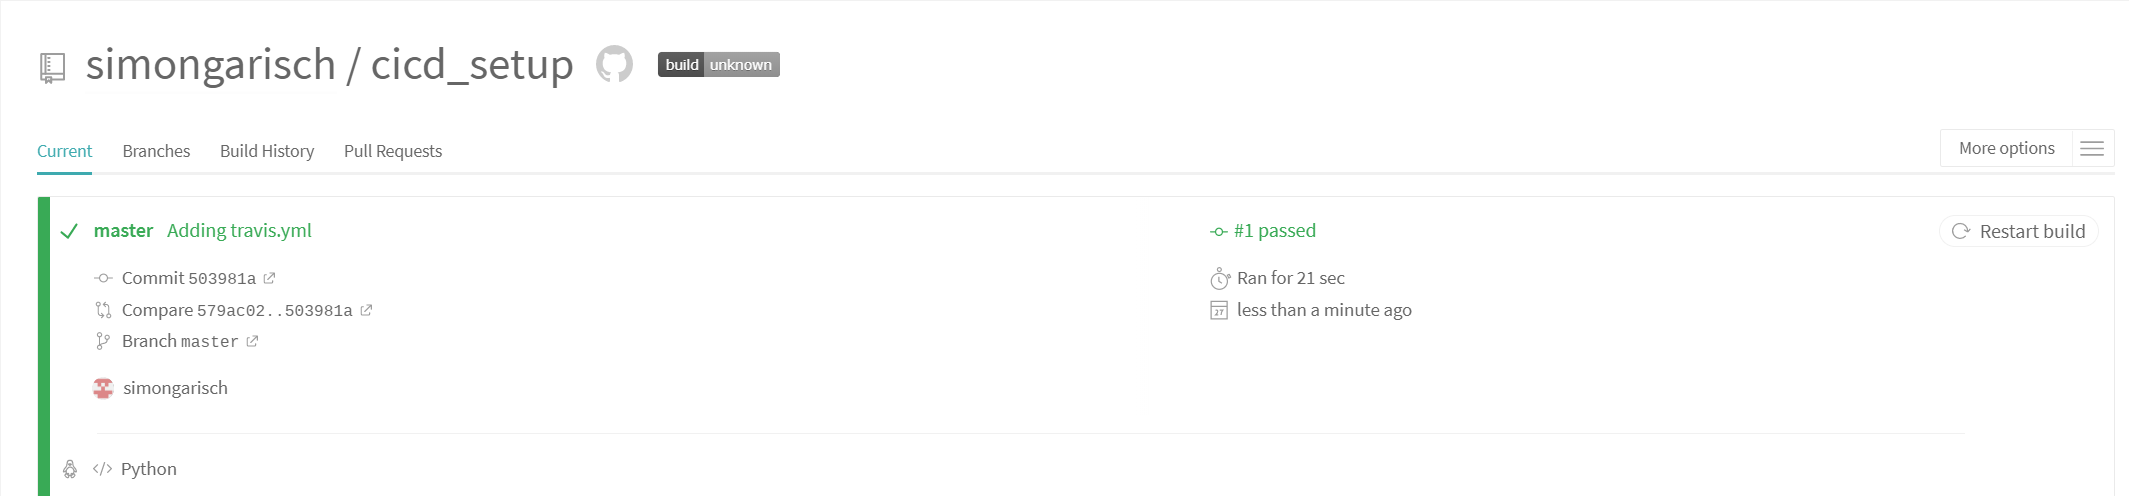

In [18]:
from IPython.display import Image
Image("travis.png")

Add a travis badge to your repo and commit the changes to github.

## Run code formatting with [black](https://github.com/python/black)

In [19]:
%%bash
source activate py36
black meaning.py
black test_meaning.py

reformatted meaning.py
All done! \u2728 \U0001f370 \u2728
1 file reformatted.
reformatted test_meaning.py
All done! \u2728 \U0001f370 \u2728
1 file reformatted.


Now add the [black badge](https://img.shields.io/badge/code%20style-black-000000.svg).

## Add [bettercodehub](https://bettercodehub.com/) to your repo
Run the code analytics on your repo and push the changes to github.

## Generate a web app for your repo

In [22]:
code = '''
import os
from flask import Flask
from meaning import meaning_of_life

app = Flask(__name__)

@app.route("/")
def get_meaning():
    page = '<html><body><h1>'
    page += str(meaning_of_life())
    page += '</h1></body></html>'
    return page

if __name__ == "__main__":
    app.run(host='0.0.0.0', port=int(os.getenv('PORT', 5000)))
'''

In [23]:
import os

file_name = "app.py"

with open(file_name, "w") as target_file:
    target_file.write(code)


We can check that this site is working...

In [ ]:
%%bash
source env/scripts/activate
python app.py

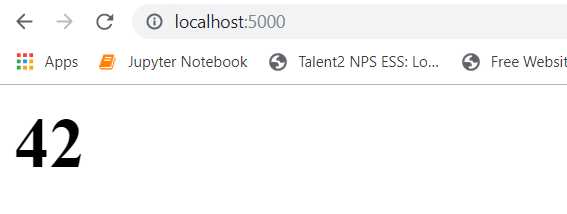

In [1]:
from IPython.display import Image
Image("site.png")

## Containerize your web app with [docker](https://hub.docker.com/_/python)
We'll use 3.6.8-alpine3.8 as the base image.

In [7]:
content = '''
FROM python:3.6.8-alpine3.8
COPY requirements.txt /src/requirements.txt
RUN pip install -r /src/requirements.txt
COPY app.py /src
COPY meaning.py /src
COPY test_meaning.py /src
CMD python /src/app.py
'''

file_name = "Dockerfile"
with open(file_name, "w") as target_file:
    target_file.write(content)


Build this docker file...

In [ ]:
%%bash
docker build -t cicd_meaning .

We can then run the dockerfile, but the web app is launched inside the container.

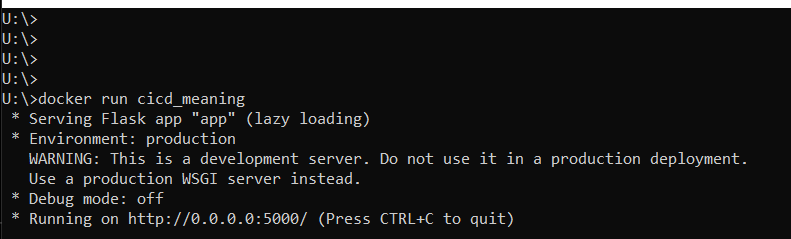

In [4]:
from IPython.display import Image
Image("running_docker.png")

In [5]:
%%bash
docker container ls

CONTAINER ID        IMAGE               COMMAND                  CREATED             STATUS              PORTS               NAMES
2d85d0e8738a        cicd_meaning        "/bin/sh -c 'python â€¦"   19 seconds ago      Up 17 seconds                           reverent_kalam


Stop the container with 'docker stop reverent_kalam'. We need to link ports to expose our app on the local machine. Here we expose port 5000 in the container to port 5001 on our local machine.

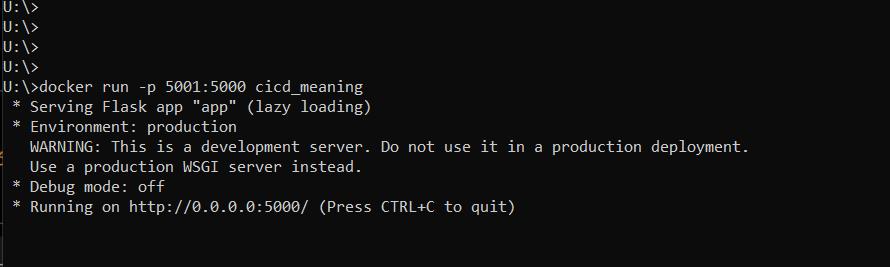

In [6]:
from IPython.display import Image
Image("app_on_5001.png")

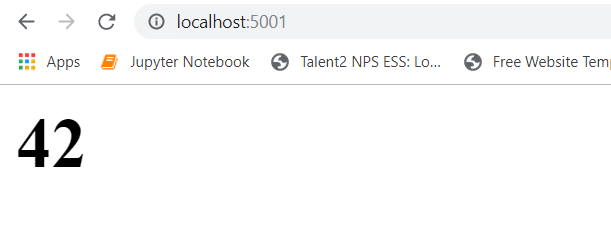

In [7]:
Image("app_on_5001_page.png")

## Deploy to Docker Hub
To complete this step youll need to sign up at https://docker.com and add the following to a file called 'deploy_dockerhub.sh' in a new directory called '.travis' in your project directory:

In [8]:
import os

file_name = "deploy_dockerhub.sh"

content = '''
docker login -u $DOCKER_USER -p $DOCKER_PASS
if [ "$TRAVIS_BRANCH" = "master" ]; then
    TAG="latest"
else
    TAG="$TRAVIS_BRANCH"
fi
docker build -f Dockerfile -t $TRAVIS_REPO_SLUG:$TAG .
docker push $TRAVIS_REPO_SLUG:$TAG
'''

with open(file_name, "w") as target_file:
    target_file.write(content)


The script above will be called by Travis CI at the end of each pipeline build and will create a new deployable Docker image for that pipeline build. The script requires 3 environment variables that you can set under the 'settings' view of your cicd_setup repo at Travis CI:

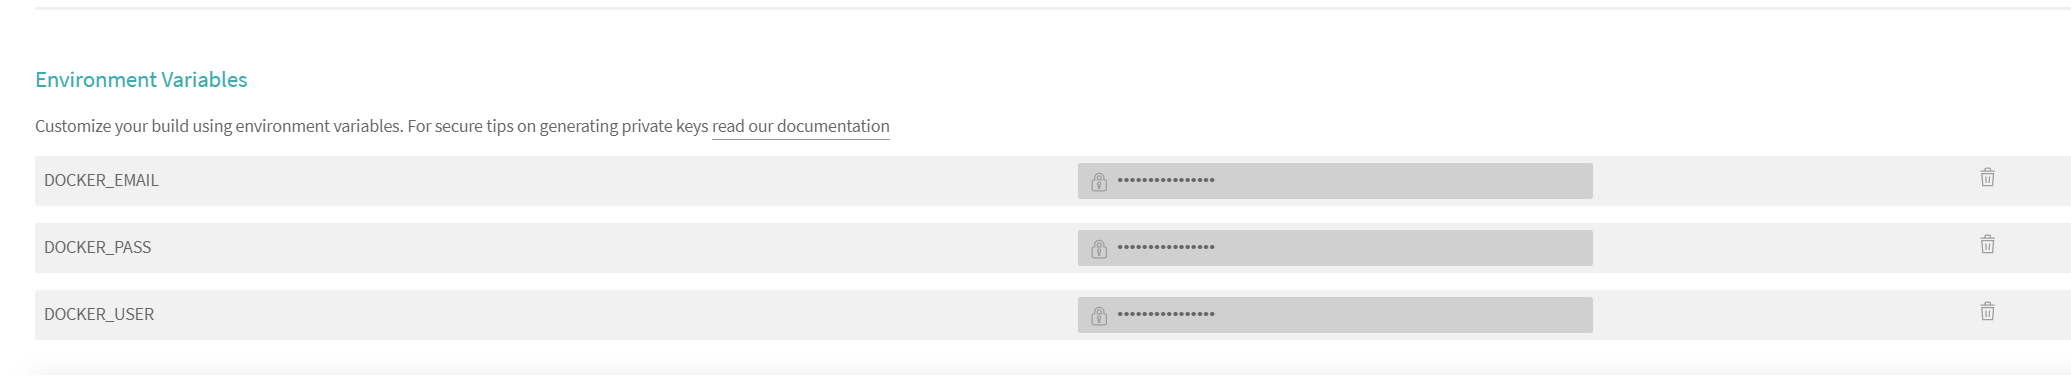

In [9]:
Image("travis_env_vars.png")

We'll also need to modify .travis.yml

In [10]:
import os

file_name = "travis.yml"

content = '''
sudo: required

services:
  - docker

language: python

script:
  - python -m pytest -v

after_success:
  - sh .travis/deploy_dockerhub.sh
'''

with open(file_name, "w") as target_file:
    target_file.write(content)


After committing changes we should now see these on dockerhub...